In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
import seaborn as sns

from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# from sklearn.impute import Imputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

In [2]:
###load application training data set
df_application_train = pd.read_csv("data/application_train.csv")
df_bureau = pd.read_csv("data/bureau.csv")

df_frames = [df_application_train, df_bureau]

# print(df_application_train.sample(5))
print(df_application_train.shape)
# print(df_application_train.info())

# print(df_bureau.sample(5))
print(df_bureau.shape)
# print(df_bureau.info())

(307511, 122)
(1716428, 17)


In [3]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in df_frames:
    #print('{}'.format(df))
    display_missing(df)
    

SK_ID_CURR column missing values: 0
TARGET column missing values: 0
NAME_CONTRACT_TYPE column missing values: 0
CODE_GENDER column missing values: 0
FLAG_OWN_CAR column missing values: 0
FLAG_OWN_REALTY column missing values: 0
CNT_CHILDREN column missing values: 0
AMT_INCOME_TOTAL column missing values: 0
AMT_CREDIT column missing values: 0
AMT_ANNUITY column missing values: 12
AMT_GOODS_PRICE column missing values: 278
NAME_TYPE_SUITE column missing values: 1292
NAME_INCOME_TYPE column missing values: 0
NAME_EDUCATION_TYPE column missing values: 0
NAME_FAMILY_STATUS column missing values: 0
NAME_HOUSING_TYPE column missing values: 0
REGION_POPULATION_RELATIVE column missing values: 0
DAYS_BIRTH column missing values: 0
DAYS_EMPLOYED column missing values: 0
DAYS_REGISTRATION column missing values: 0
DAYS_ID_PUBLISH column missing values: 0
OWN_CAR_AGE column missing values: 202929
FLAG_MOBIL column missing values: 0
FLAG_EMP_PHONE column missing values: 0
FLAG_WORK_PHONE column missi

In [4]:
threshold = 0.75
# #Dropping columns with missing value rate higher than threshold
df_application_train = df_application_train[df_application_train.columns[df_application_train.isnull().mean() < threshold]]


# #Dropping rows with missing value rate higher than threshold
df_application_train = df_application_train.loc[df_application_train.isnull().mean(axis=1) < threshold]
# print(df_application_train)


df_bureau = df_bureau.loc[df_bureau.isnull().mean(axis=1) <threshold]
#print(df_bureau)

#Filling missing values with mode of the columns
df_application_train = df_application_train.fillna(df_application_train.median())


###### categorical data#########
categorical_feature_mask = df_application_train.dtypes==object
categorical_cols = df_application_train.columns[categorical_feature_mask].tolist()

for col in categorical_cols:
    print(col)
    df_application_train[col].fillna(df_application_train[col].value_counts().idxmax(), inplace=True)
print("train data shape",df_application_train.shape)


df_bureau = df_bureau.dropna()
print("bureau data shape",df_bureau.shape)




NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
train data shape (307511, 122)
bureau data shape (39666, 17)


In [5]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

display_missing(df_application_train)
display_missing(df_bureau)



SK_ID_CURR column missing values: 0
TARGET column missing values: 0
NAME_CONTRACT_TYPE column missing values: 0
CODE_GENDER column missing values: 0
FLAG_OWN_CAR column missing values: 0
FLAG_OWN_REALTY column missing values: 0
CNT_CHILDREN column missing values: 0
AMT_INCOME_TOTAL column missing values: 0
AMT_CREDIT column missing values: 0
AMT_ANNUITY column missing values: 0
AMT_GOODS_PRICE column missing values: 0
NAME_TYPE_SUITE column missing values: 0
NAME_INCOME_TYPE column missing values: 0
NAME_EDUCATION_TYPE column missing values: 0
NAME_FAMILY_STATUS column missing values: 0
NAME_HOUSING_TYPE column missing values: 0
REGION_POPULATION_RELATIVE column missing values: 0
DAYS_BIRTH column missing values: 0
DAYS_EMPLOYED column missing values: 0
DAYS_REGISTRATION column missing values: 0
DAYS_ID_PUBLISH column missing values: 0
OWN_CAR_AGE column missing values: 0
FLAG_MOBIL column missing values: 0
FLAG_EMP_PHONE column missing values: 0
FLAG_WORK_PHONE column missing values: 

In [6]:
########################### joining appication train bureau table ###############

# Combining numerical features
grp = df_bureau.drop(['SK_ID_BUREAU'], axis = 1).groupby(by=['SK_ID_CURR']).mean().reset_index()
grp.columns = ['BUREAU_'+column if column !='SK_ID_CURR' else column for column in grp.columns]
df_application_bureau = df_application_train.merge(grp, on='SK_ID_CURR', how='left')
df_application_bureau.update(df_application_bureau[grp.columns].fillna(0))

###Combining categorical features
df_bureau_categorical = pd.get_dummies(df_bureau.select_dtypes('object'))
df_bureau_categorical['SK_ID_CURR'] = df_bureau['SK_ID_CURR']
grp = df_bureau_categorical.groupby(by = ['SK_ID_CURR']).mean().reset_index()
grp.columns = ['BUREAU_'+column if column !='SK_ID_CURR' else column for column in grp.columns]
df_application_bureau = df_application_bureau.merge(grp, on='SK_ID_CURR', how='left')
df_application_bureau.update(df_application_bureau[grp.columns].fillna(0))

####Shape of application and bureau data combined
print('after joining application table and bureau table the combined table shape:',df_application_bureau.shape)
print(df_application_bureau.sample(5))

after joining application table and bureau table the combined table shape: (307511, 150)
        SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
268798      411500       0    Revolving loans           M            Y   
254725      394755       0         Cash loans           M            N   
137954      259987       0         Cash loans           F            Y   
205590      338310       0         Cash loans           F            Y   
136002      257751       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
268798               Y             0          360000.0    540000.0   
254725               Y             0          135000.0    405000.0   
137954               Y             0           54000.0     71955.0   
205590               Y             0          180000.0    508495.5   
136002               Y             0          202500.0   1288350.0   

        AMT_ANNUITY  ...  BUREAU_CREDIT_CURRE

In [7]:
################ data encoding ####################

categorical_feature_mask = df_application_bureau.dtypes==object
# filter categorical columns using mask and turn it into a list
non_numeric_features = df_application_bureau.columns[categorical_feature_mask].tolist()
print(non_numeric_features)

le = LabelEncoder()
df_application_bureau[non_numeric_features] = df_application_bureau[non_numeric_features].apply(lambda col: le.fit_transform(col))
print(df_application_bureau.shape)
print(df_application_bureau.sample(5))


['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
(307511, 150)
        SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
262603      404043       0                   0            1             1   
197562      329056       0                   1            1             1   
67944       178791       0                   0            1             0   
215492      349690       0                   0            0             1   
230732      367254       0                   0            0             1   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
262603                1             0          315000.0   1030680.0   
197562                0             0          2

In [8]:

###################### normalization of data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

scaler.fit(df_application_bureau)
df_application_bureau_norm = scaler.transform(df_application_bureau)
print(df_application_bureau_norm.shape)



(307511, 150)


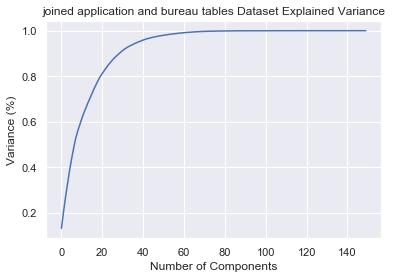

In [9]:
##################### dimension reduction ################### 

############ number of pca component analysis ###############


scaler = MinMaxScaler(feature_range=[0, 1])

######## pca anaylsis for joined table ###########
data_rescaled = scaler.fit_transform(df_application_bureau)


#Fitting the PCA algorithm with our Data
pca = PCA().fit(data_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('joined application and bureau tables Dataset Explained Variance')
plt.show()

In [10]:
############ Make a pipeline with pca

from sklearn.decomposition import PCA
# pca = PCA(n_components=50 , random_state=420)
pca = PCA(n_components=60 , random_state=420)

df_application_bureau_pca = pca.fit_transform(df_application_bureau)

print(df_application_bureau_pca.shape)
print(df_application_bureau_pca)

(307511, 60)
[[-2.62536127e+05  6.15561459e+04 -7.03719402e+04 ... -1.09826241e-01
  -3.27110312e-01 -3.28480560e-02]
 [ 9.17644577e+05  2.58408855e+04 -4.62993139e+04 ...  8.47437289e-03
  -4.78187440e-03  6.15370738e-02]
 [-6.19992881e+05 -4.51215487e+04 -7.79317897e+04 ...  1.55775060e-01
  -1.18383384e-02 -1.42448327e-01]
 ...
 [ 8.91214678e+04 -2.02874391e+04 -7.04148608e+04 ... -2.99820115e-01
  -9.23097468e-02 -2.94074843e-01]
 [-3.14120713e+05  3.22138596e+04 -7.23808522e+04 ...  2.05957593e-01
   2.49391511e-02  1.59668611e-01]
 [ 1.48383497e+05 -2.08791001e+04 -6.24148680e+04 ... -3.60424358e-01
  -1.46919710e-03  8.03102340e-02]]


In [11]:
################## x _train , y_train , x_test #################

df =  pd.DataFrame(df_application_bureau_pca)
# print(df)
# y = df[df.columns[0],df.columns[1]]
X = df.drop([df.columns[0], df.columns[1]] ,  axis='columns')


df = df_application_bureau
y = df.iloc[: , [1]]
# X = df.drop([df.columns[0], df.columns[1]] ,  axis='columns')


from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=1)

# print(X_train.shape)
# print(y_train.shape)
# print(y_train)
# print(X_train)
# print(X_test.shape)
# print(y_test.shape)



C:\Users\binuri\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


k value = 1
confusion matrix
[[52089  4444]
 [ 4455   515]]


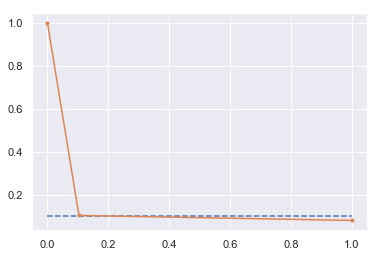

C:\Users\binuri\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


k value = 2
confusion matrix
[[56106   427]
 [ 4906    64]]


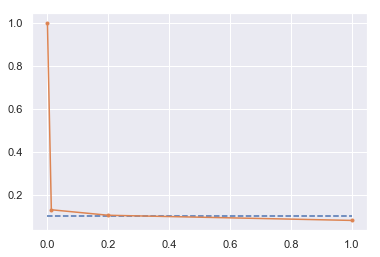

C:\Users\binuri\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


k value = 3
confusion matrix
[[55340  1193]
 [ 4798   172]]


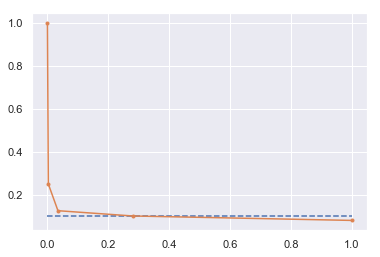

C:\Users\binuri\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


k value = 4
confusion matrix
[[56342   191]
 [ 4933    37]]


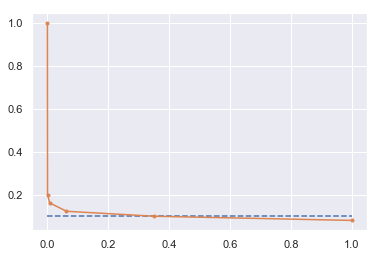

C:\Users\binuri\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


k value = 5
confusion matrix
[[56110   423]
 [ 4896    74]]


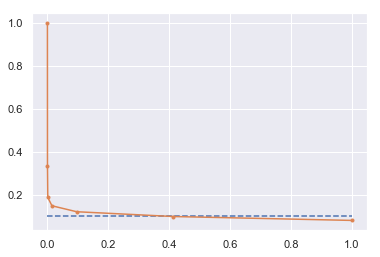

C:\Users\binuri\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


k value = 6
confusion matrix
[[56466    67]
 [ 4956    14]]


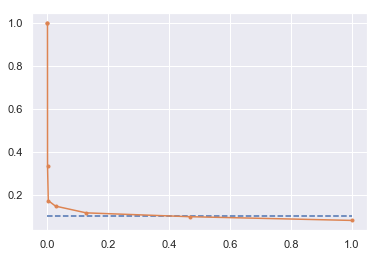

C:\Users\binuri\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


k value = 7
confusion matrix
[[56393   140]
 [ 4939    31]]


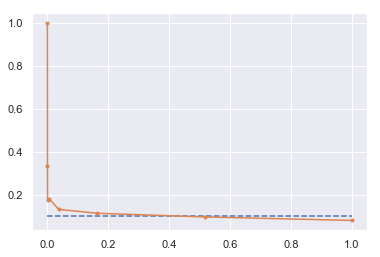

C:\Users\binuri\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


k value = 8
confusion matrix
[[56499    34]
 [ 4959    11]]


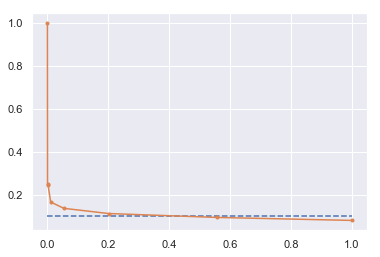

C:\Users\binuri\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


k value = 9
confusion matrix
[[56471    62]
 [ 4954    16]]


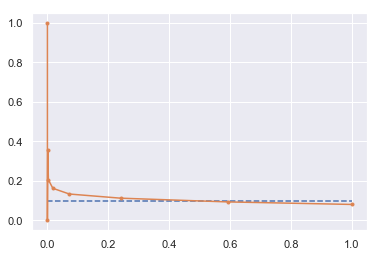

In [18]:
# #################### kNN model for various k values #############

k_range = range(1, 10)
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print("k value =" ,k)
    
    print("confusion matrix")
    print(confusion_matrix(y_test,y_pred))
    

    
#     probs = knn.predict_proba(X_test)
#     probs = probs[:, 1]  
#     # calculate AUC
#     auc = roc_auc_score(y_test, probs)
#     print('AUC: %.3f' % auc)
#     # calculate roc curve
#     fpr, tpr, thresholds = roc_curve(y_test, probs)
#     # plot no skill
#     pyplot.plot([0, 1], [0, 1], linestyle='--')
#     # plot the roc curve for the model
#     pyplot.plot(fpr, tpr, marker='.')
#     # show the plot
#     pyplot.show()



    ####predict probabilities
    probs = knn.predict_proba(X_test)
    probs = probs[:, 1]
    
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    # calculate F1 score
    f1 = f1_score(y_test, y_pred)
    # calculate precision-recall AUC
#     auc = auc(recall, precision)
    # calculate average precision score
    ap = average_precision_score(y_test, probs)
#     print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
    # plot no skill
    pyplot.plot([0, 1], [0.1, 0.1], linestyle='--')
    # plot the precision-recall curve for the model
    pyplot.plot(recall, precision, marker='.')
    # show the plot
    pyplot.show()




In [ ]:
# ######################## logistic regression algorithm #######################

logmodel = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver= 'lbfgs', tol=0.0001,
           verbose=0, warm_start=False)

logmodel.fit(X_train,y_train)
y_pred = logmodel.predict(X_test)
print ("Predicted Value:", y_pred)

# # summarize the fit of the model
# print(classification_report(y_test,y_pred))
# print("confusion matrix")
# print(confusion_matrix(y_test,y_pred))
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [1]:
######################## svm algorithm #######################
################################################# linear kernel

svc_model = SVC(kernel='linear').fit(X_train, y_train)
svc_model.fit(X_train, y_train)
y_pred = svc_model.predict(X_test)
# print ("Predicted Value:", y_pred)
print("confusion matrix")
print(confusion_matrix(y_test,y_pred))

# # predict probabilities
# probs = svc_model.predict_proba(X_test)
# probs = probs[:, 1]

# # calculate AUC
# auc = roc_auc_score(y_test, probs)
# print('AUC: %.3f' % auc)
# # calculate roc curve
# fpr, tpr, thresholds = roc_curve(y_test, probs)
# # plot no skill
# pyplot.plot([0, 1], [0, 1], linestyle='--')
# # plot the roc curve for the model
# pyplot.plot(fpr, tpr, marker='.')
# # show the plot
# pyplot.show()

####predict probabilities
probs = svc_model.predict_proba(X_test)
probs = probs[:, 1]

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
# calculate F1 score
f1 = f1_score(y_test, y_pred)
# calculate precision-recall AUC
#     auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test, probs)
#     print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.1, 0.1], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()





################################################## rbf kernel
svc_model = SVC(kernel='rbf').fit(X_train, y_train)
svc_model.fit(X_train, y_train)
y_pred = svc_model.predict(X_test)
# print ("Predicted Value:", y_pred)
print("confusion matrix")
print(confusion_matrix(y_test,y_pred))

# # predict probabilities
# probs = svc_model.predict_proba(X_test)
# probs = probs[:, 1]

# # calculate AUC
# auc = roc_auc_score(y_test, probs)
# print('AUC: %.3f' % auc)
# # calculate roc curve
# fpr, tpr, thresholds = roc_curve(y_test, probs)
# # plot no skill
# pyplot.plot([0, 1], [0, 1], linestyle='--')
# # plot the roc curve for the model
# pyplot.plot(fpr, tpr, marker='.')
# # show the plot
# pyplot.show()


####predict probabilities
probs = svc_model.predict_proba(X_test)
probs = probs[:, 1]

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
# calculate F1 score
f1 = f1_score(y_test, y_pred)
# calculate precision-recall AUC
#     auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test, probs)
#     print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.1, 0.1], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()





#########################################  poly kernel
# svc_model = SVC(kernel='poly').fit(X_train, y_train)
# svc_model.fit(X_train, y_train)
# y_pred = svc_model.predict(X_test)
# # print ("Predicted Value:", y_pred)
# print("confusion matrix")
# print(confusion_matrix(y_test,y_pred))

# # predict probabilities
# probs = svc_model.predict_proba(X_test)
# probs = probs[:, 1]

# # calculate AUC
# auc = roc_auc_score(y_test, probs)
# print('AUC: %.3f' % auc)
# # calculate roc curve
# fpr, tpr, thresholds = roc_curve(y_test, probs)
# # plot no skill
# pyplot.plot([0, 1], [0, 1], linestyle='--')
# # plot the roc curve for the model
# pyplot.plot(fpr, tpr, marker='.')
# # show the plot
# pyplot.show()



####predict probabilities
probs = svc_model.predict_proba(X_test)
probs = probs[:, 1]

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
# calculate F1 score
f1 = f1_score(y_test, y_pred)
# calculate precision-recall AUC
#     auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test, probs)
#     print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.1, 0.1], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()


NameError: name 'SVC' is not defined